In [1]:
import logging
import shlex
import sys
from pathlib import Path
from typing import Dict, Tuple, Union

import elettra_toolbox
from elettra_toolbox import ScanConfig
from cpymad.madx import Madx

LOGGER = logging.getLogger(name=__name__)
LOGGER.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
LOGGER.addHandler(handler)

import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from matplotlib import cm, gridspec, patches
from pyhdtoolkit import cpymadtools

plt.rcParams.update({"text.usetex": False})

In [2]:
if os.path.exists("stdout.out"):
    os.remove("stdout.out")

# Launch MAD-X Session
with open("stdout.out", "w") as f:
    madx = Madx(stdout=f)

# Read parameters

from config import parameters, settings

for i in parameters.keys():
    madx.globals[i] = parameters[i]

# Call sequence and optics

madx.call("elettra2_v15_VADER_2.3T.madx")
madx.call("optics_elettra2_v15_VADER_2.3T.madx")

# Initial twiss

madx.use(sequence="ring")
madx.twiss(sequence="ring", table="init_twiss")

# Compute Emittance

madx.input(
    f"""
emit, deltap={madx.globals.deltap};
emit, deltap={madx.globals.deltap};
"""
)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

twiss = madx.table.init_twiss.dframe()


# Let's install some markers

madx.input(
    """
left_marker: marker;
right_marker: marker;
middle_marker: marker;

use, sequence=ring;
seqedit, sequence=ring;
flatten;
install, element=left_marker, at=10.8;
install, element=middle_marker, at=21.6;
install, element=right_marker, at=32.4;
flatten;
endedit;
"""
)

madx.use(sequence="ring")
madx.twiss(sequence="ring")
twiss = madx.table.twiss.dframe()

Emittance x : 164.73136 pm


In [3]:
# Check that the machine is closed

tol_x_survey, tol_z_survey =  elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


2021-10-28 10:35:46.649 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-28 10:35:46.652 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-28 10:35:47.361 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-28 10:35:47.465 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-28 10:35:49.325 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-28 10:35:49.354 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-28 10:35:49.385 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


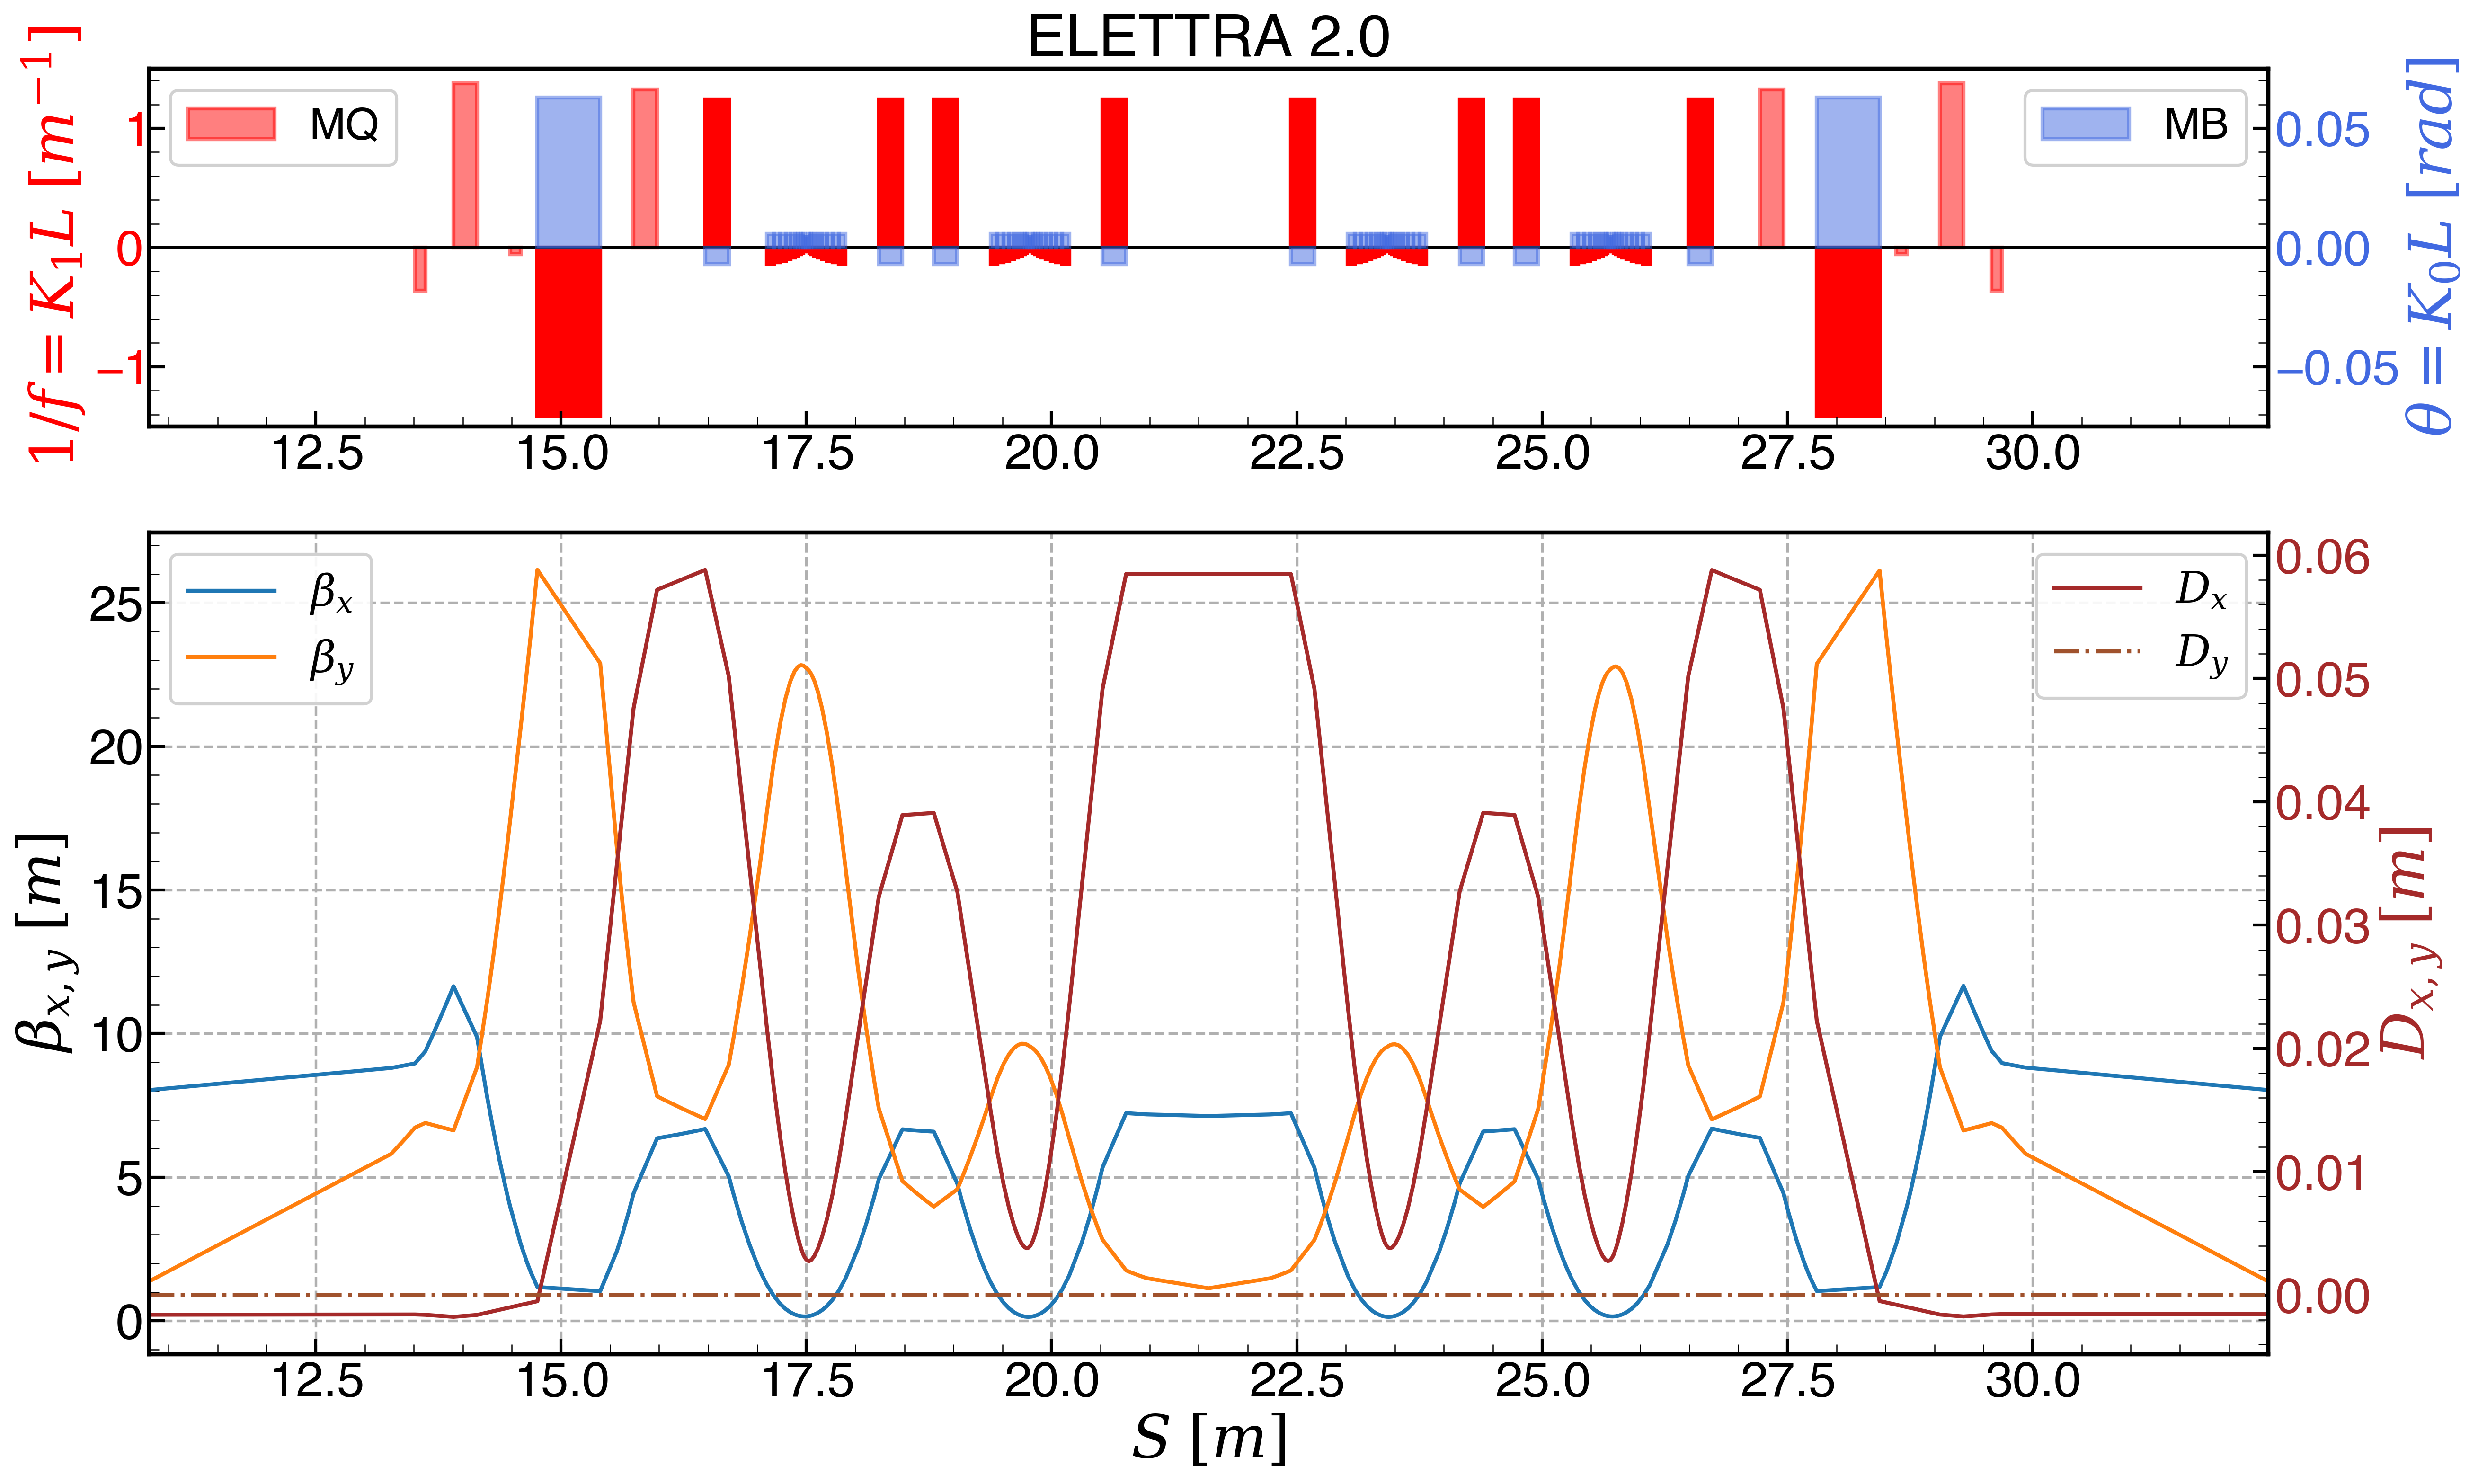

In [4]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [8]:
madx.input('''

!match, range=left_marker[1]/right_marker[1];
match, sequence=ring;
vary, name=k1_qd1, step=1e-6;
vary, name=k1_qd2, step=1e-6;
vary, name=k1_qf1, step=1e-6;
vary, name=k1_qf2, step=1e-6;

constraint, range=right_marker[1], dx=0, dy=0;
constraint, range=left_marker[1], dx=0, dy=0;
!constraint, range=middle_marker[1], dx=0.058472, dy=0;

lmdif, calls=2000, tolerance=1e-21;
endmatch;
''')

print(madx.globals.tar)

2.792922593108147e-19


2021-10-28 10:37:09.336 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-28 10:37:09.337 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-28 10:37:10.057 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-28 10:37:10.161 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-28 10:37:12.078 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-28 10:37:12.248 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-28 10:37:12.279 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


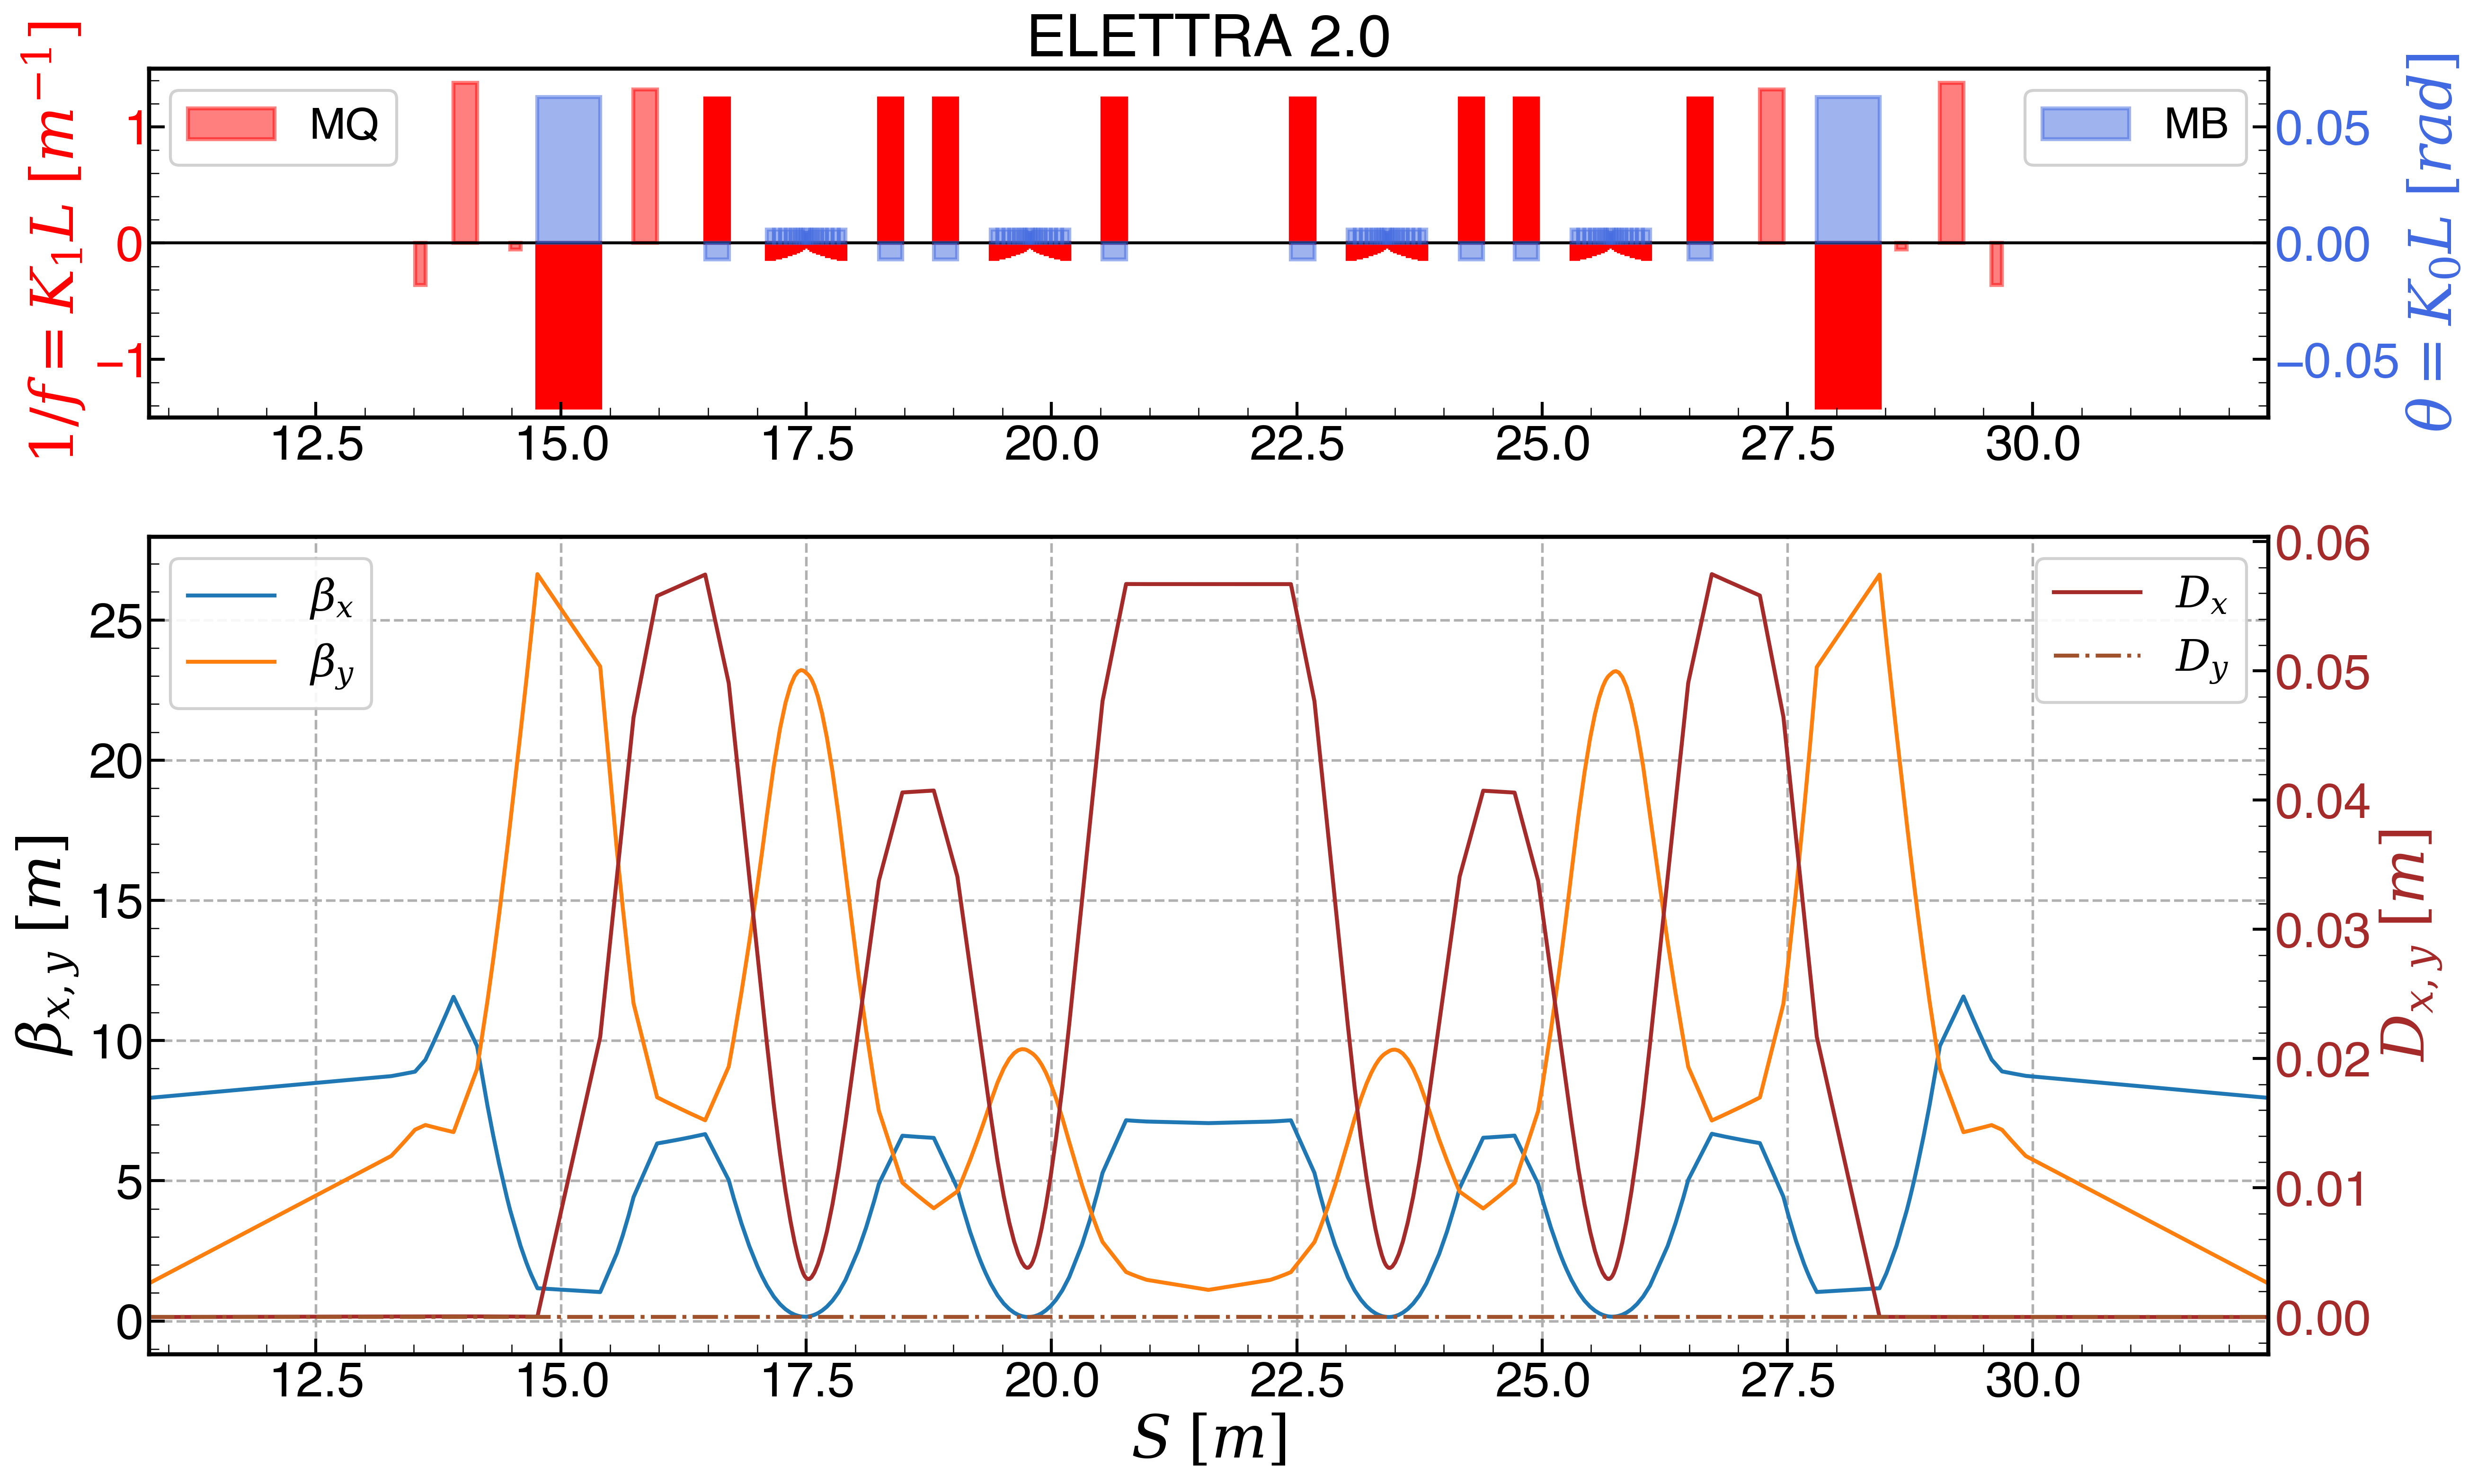

In [9]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [11]:
# Compute Emittance

madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 159.96399 pm


2021-10-28 10:38:34.209 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-28 10:38:34.210 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-28 10:38:34.952 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-28 10:38:35.055 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-28 10:38:37.061 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-28 10:38:37.087 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-28 10:38:37.117 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


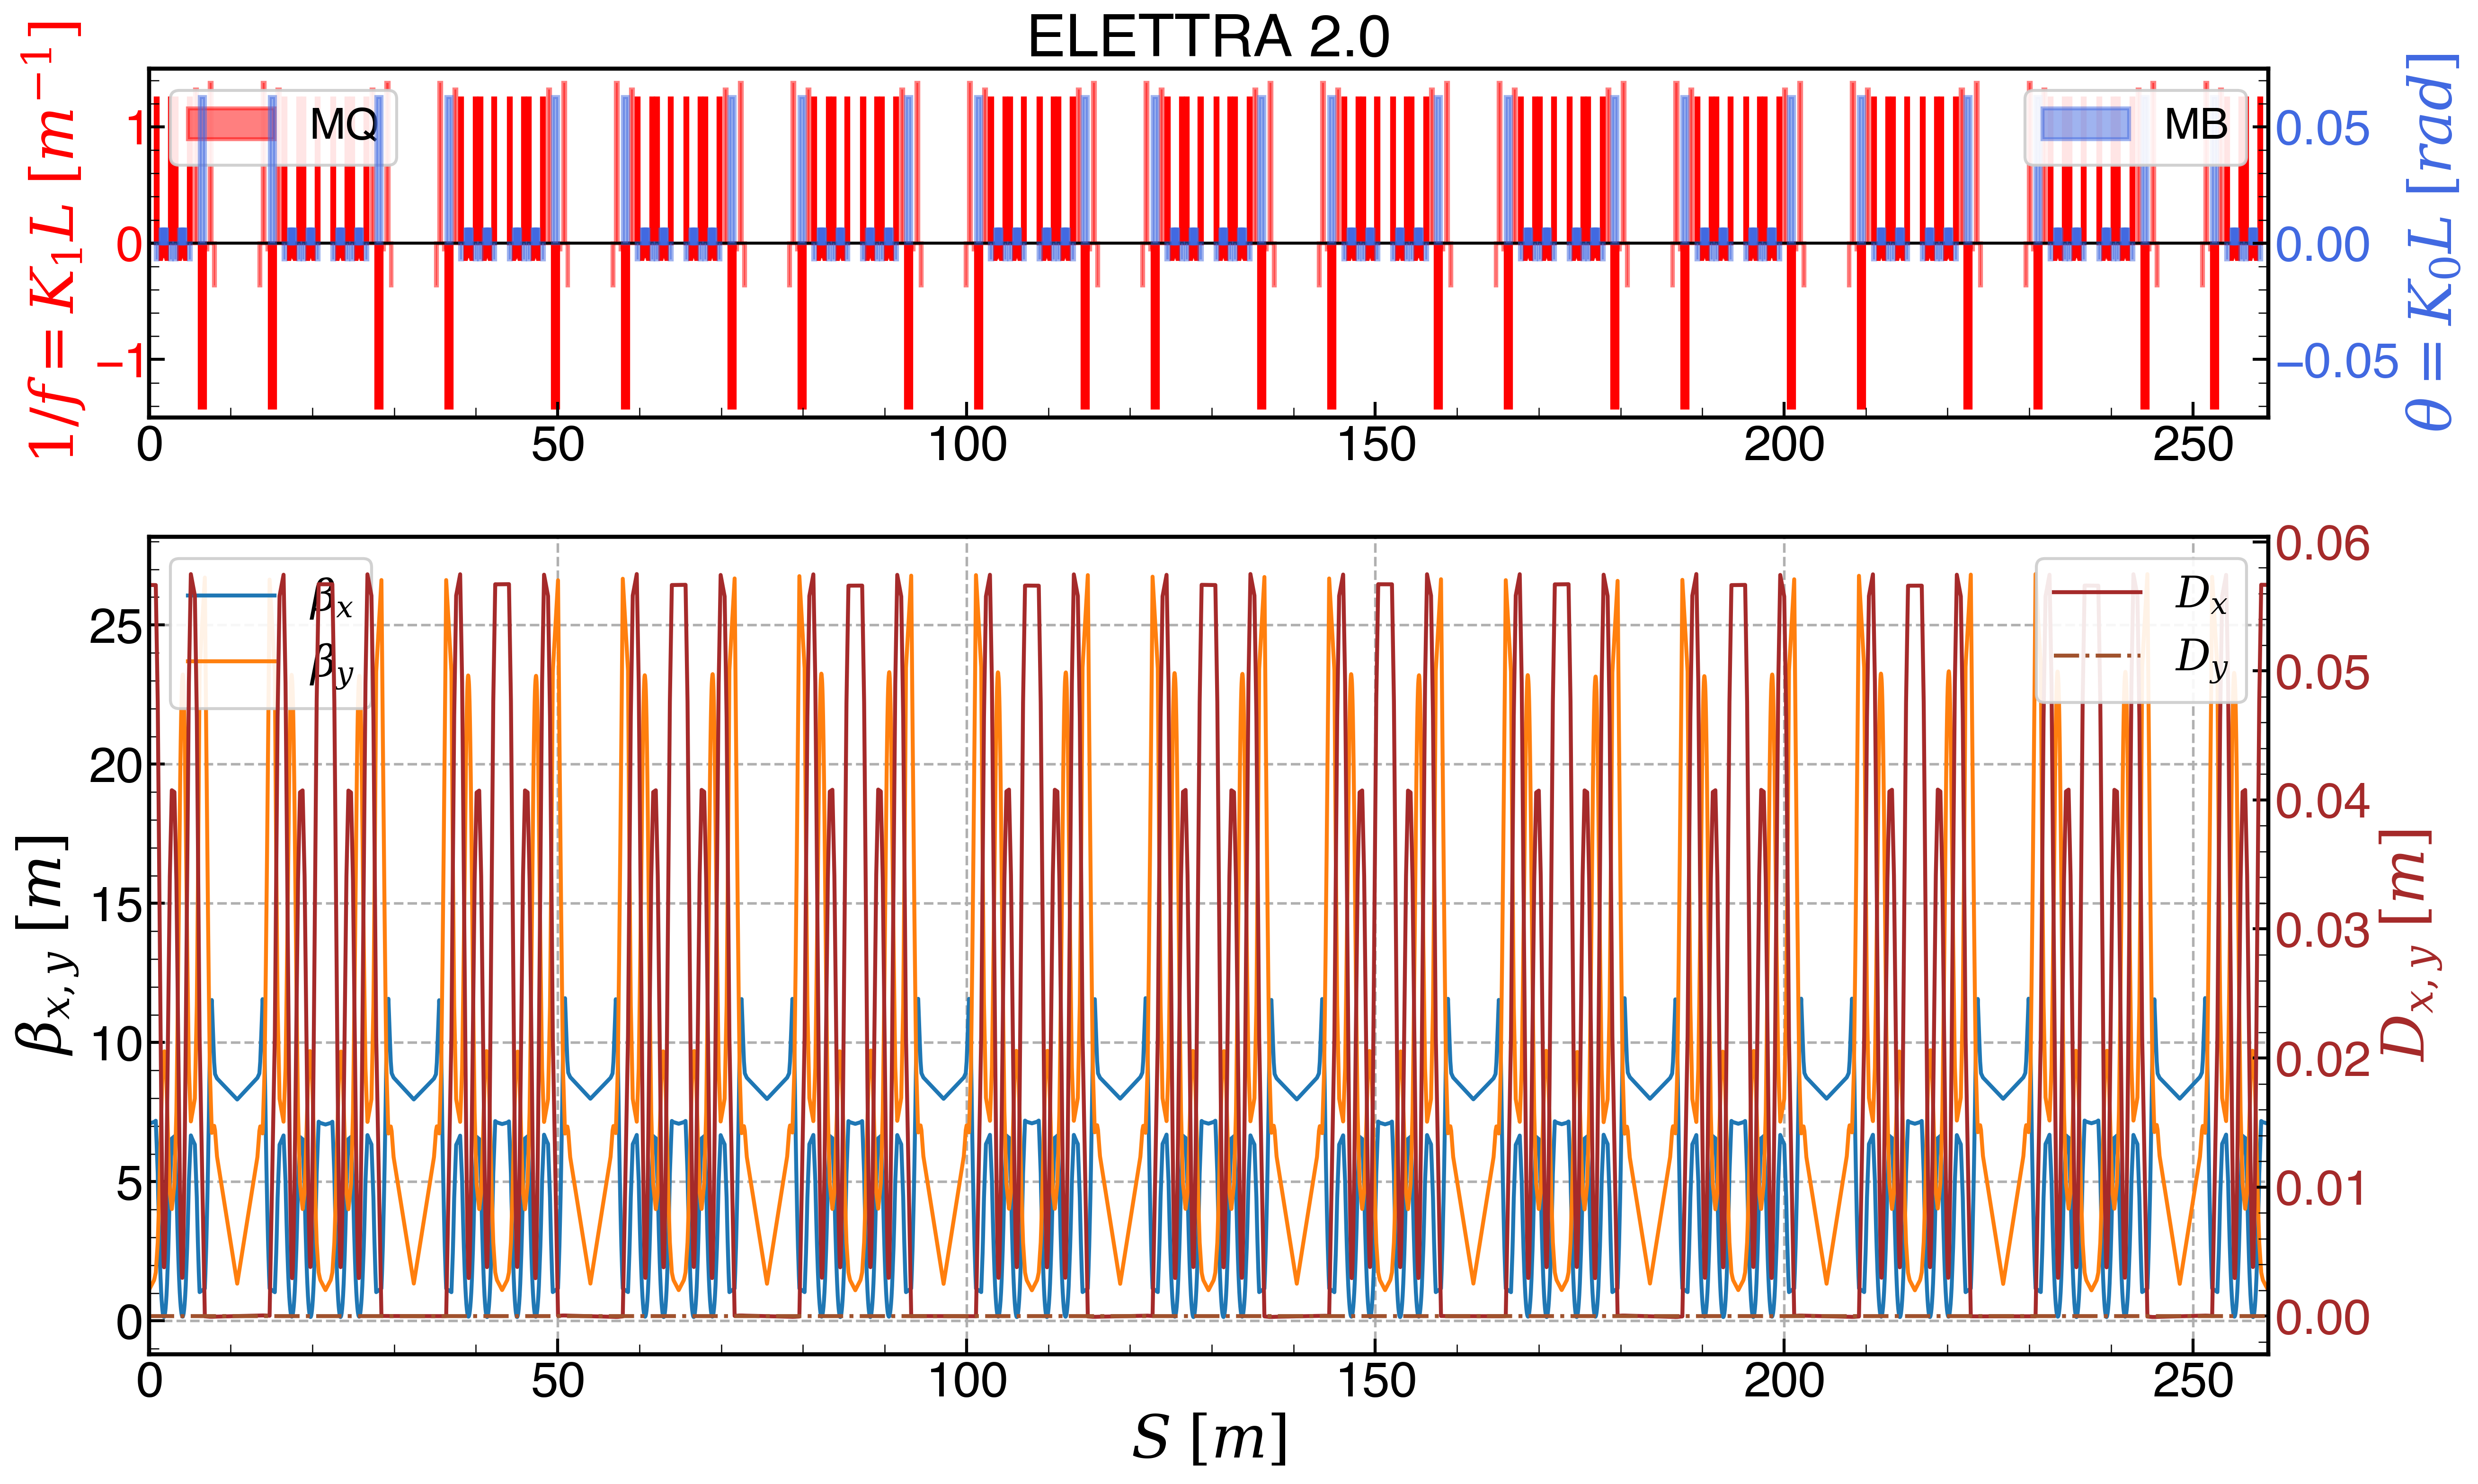

In [12]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [13]:
elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


(4.462588843305942e-09, 0.000607627269749389)

In [14]:
madx.twiss();
test_twiss = madx.table.twiss.dframe()


In [17]:
test_twiss['angle'].sum()/2/np.pi

1.0000023384349968

In [19]:
initial_angle_ab = -0.006981

In [20]:
madx.globals.angle_bqf1 = initial_angle_ab*4
madx.globals.angle_bqf2 = 0
madx.globals.angle_bqf3 = 0
madx.globals.angle_bqf4 = 0

In [21]:
madx.twiss(table='single_ab');
twiss_single_ab = madx.table.single_ab.dframe()

In [22]:
elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


(4.46545257422074e-09, 0.0006080484444823675)

2021-10-28 10:44:19.466 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-28 10:44:19.467 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-28 10:44:20.199 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-28 10:44:20.301 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-28 10:44:22.241 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-28 10:44:22.269 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-28 10:44:22.302 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


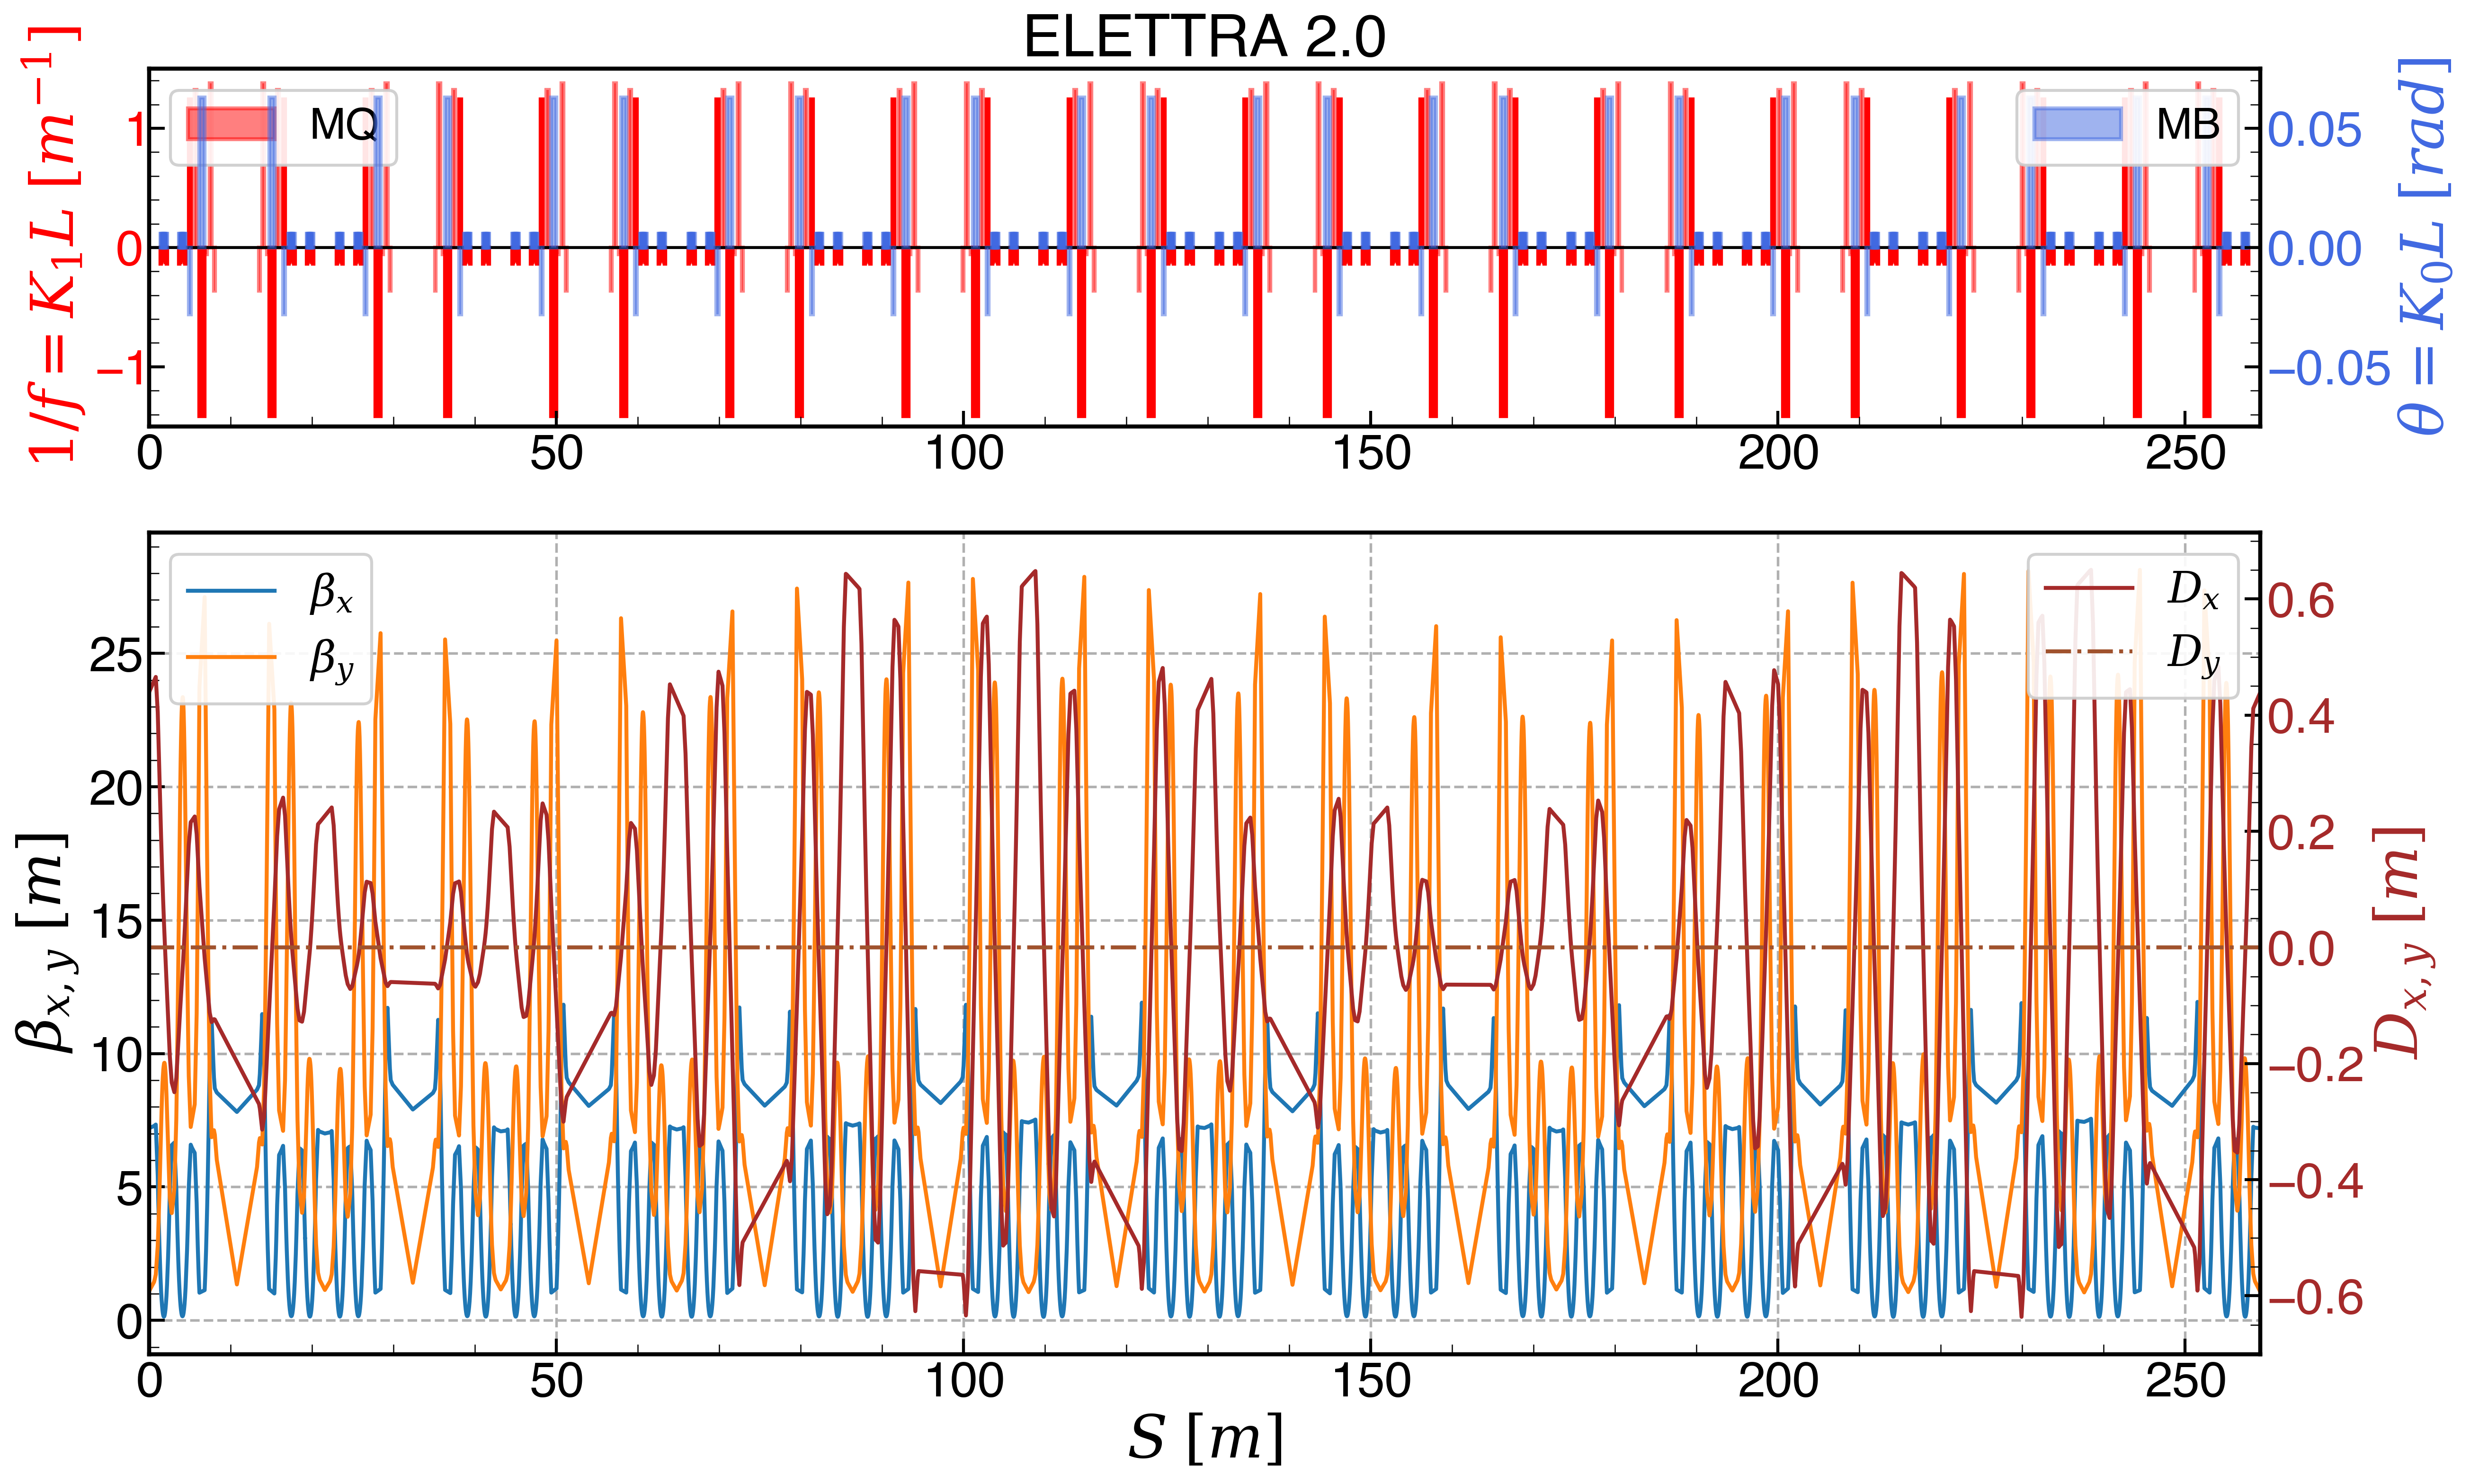

In [24]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

2021-10-28 10:44:45.779 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-28 10:44:45.780 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-28 10:44:46.506 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-28 10:44:46.609 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-28 10:44:48.468 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-28 10:44:48.496 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-28 10:44:48.526 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate


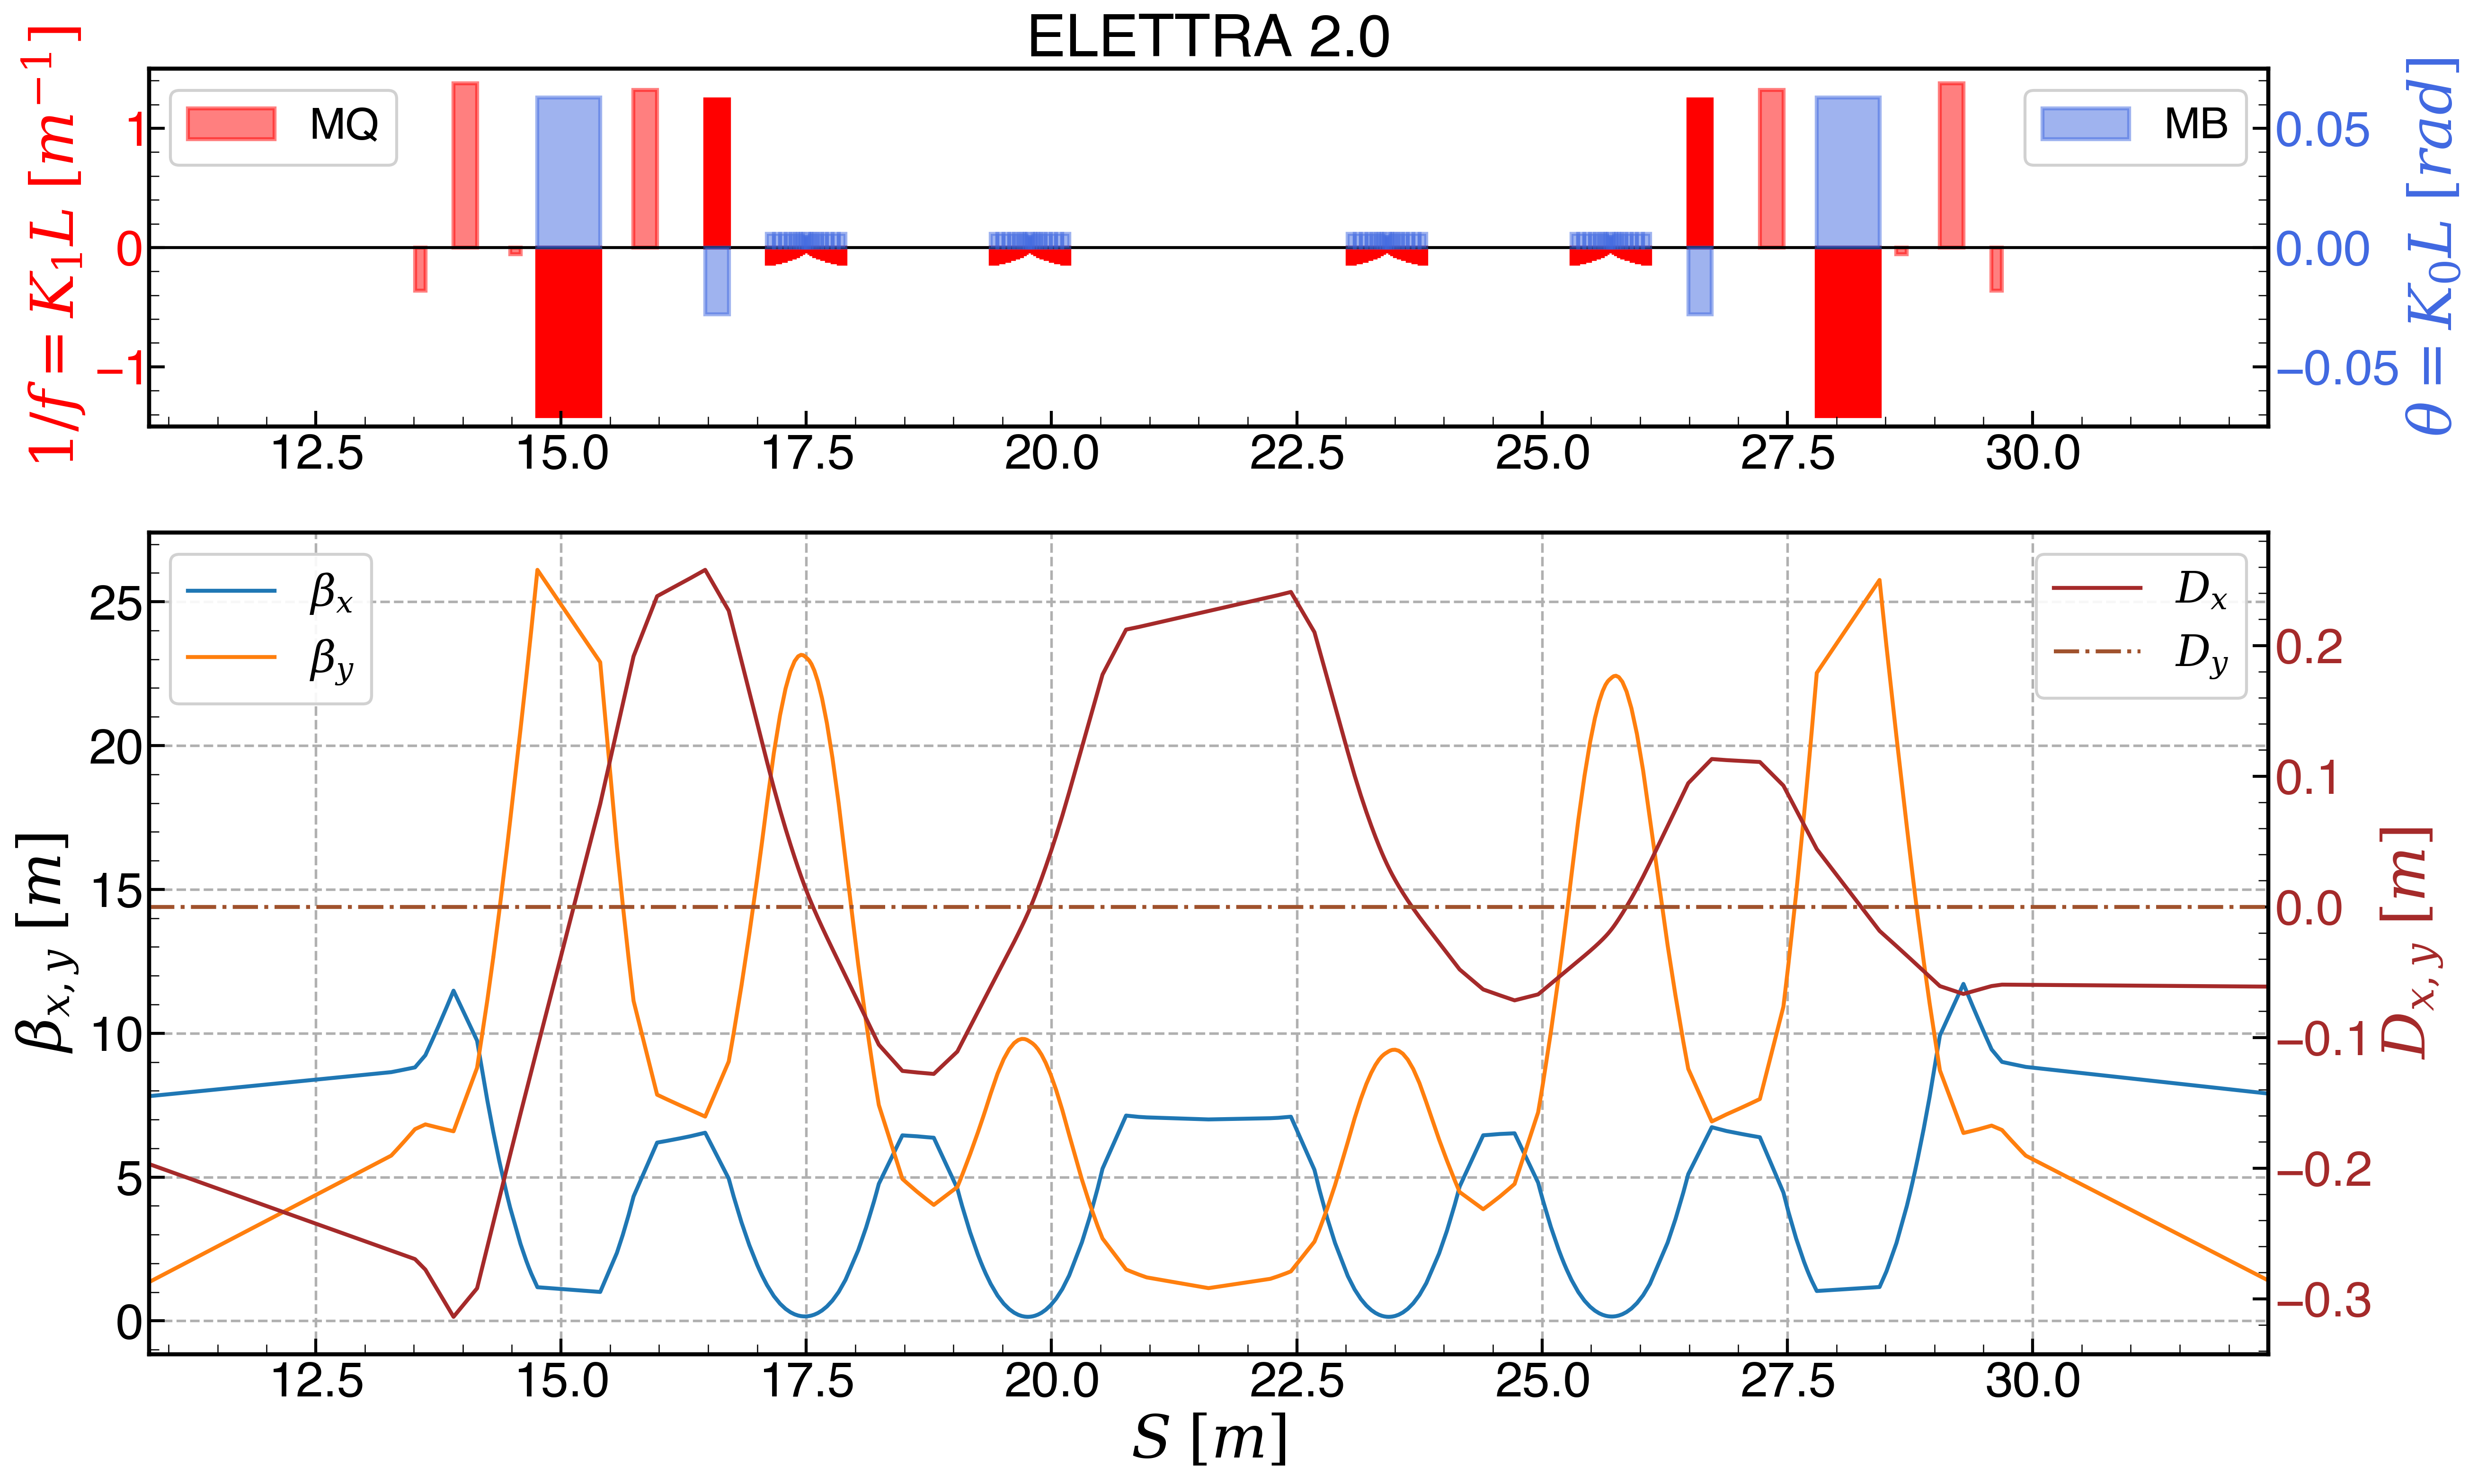

In [25]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [26]:
madx.input('''

!match, range=left_marker[1]/right_marker[1];
match, sequence=ring;
vary, name=k1_qd1, step=1e-6;
vary, name=k1_qd2, step=1e-6;
vary, name=k1_qf1, step=1e-6;
vary, name=k1_qf2, step=1e-6;

constraint, range=right_marker[1], dx=0, dy=0;
constraint, range=left_marker[1], dx=0, dy=0;
!constraint, range=middle_marker[1], dx=0.058472, dy=0;

lmdif, calls=2000, tolerance=1e-21;
endmatch;
''')

print(madx.globals.tar)

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


4.2491043938008035
